# Memorization vs Generalization

Neuronale Netze werden immer größer. 

## Lernen

Der Begriff _lernen_ lässt in diesem Zusammenhang zwei Interpretationen zu.
- "Learning by memorization".
- _Generalisierung_: Aus den Trainingsdaten werden Features extrahiert, mit deren Hilfe unbekannte Daten entsprechend klassifiziert werden.

[Beleg?] 

In heutigen Machine Learning-Anwendungsgebieten meint der Begriff _lernen_ zweiteres. In diesem Notebook wird der Begriff entsprechend verwendet. 



## Kapazität 

Jedes mathmatische Modell bestetht aus einer Anzahl bestimmten Anzahl an Parametern. Diese beschränken die Möglichkeit eines Modells, sich einer beliebigen Funktion anzunähern. Die Kapazität eines Neuronalen Netzwerkes bestimmt sich durch die Anzahl und Größe der verstecken Schichten. Als Richtwert, lässt sich die Anzahl der Parameter nutzen. 
Eine exakte Angabe der Kapazität ist jedoch nur schwer möglich. \cite{Deep Learning}



In [38]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
import random, os, json

FORCE_BUILD_MODELS = False

Wir verwenden zu demonstrationszwecken das CIFAR10 Dataset, welches aus 50000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 

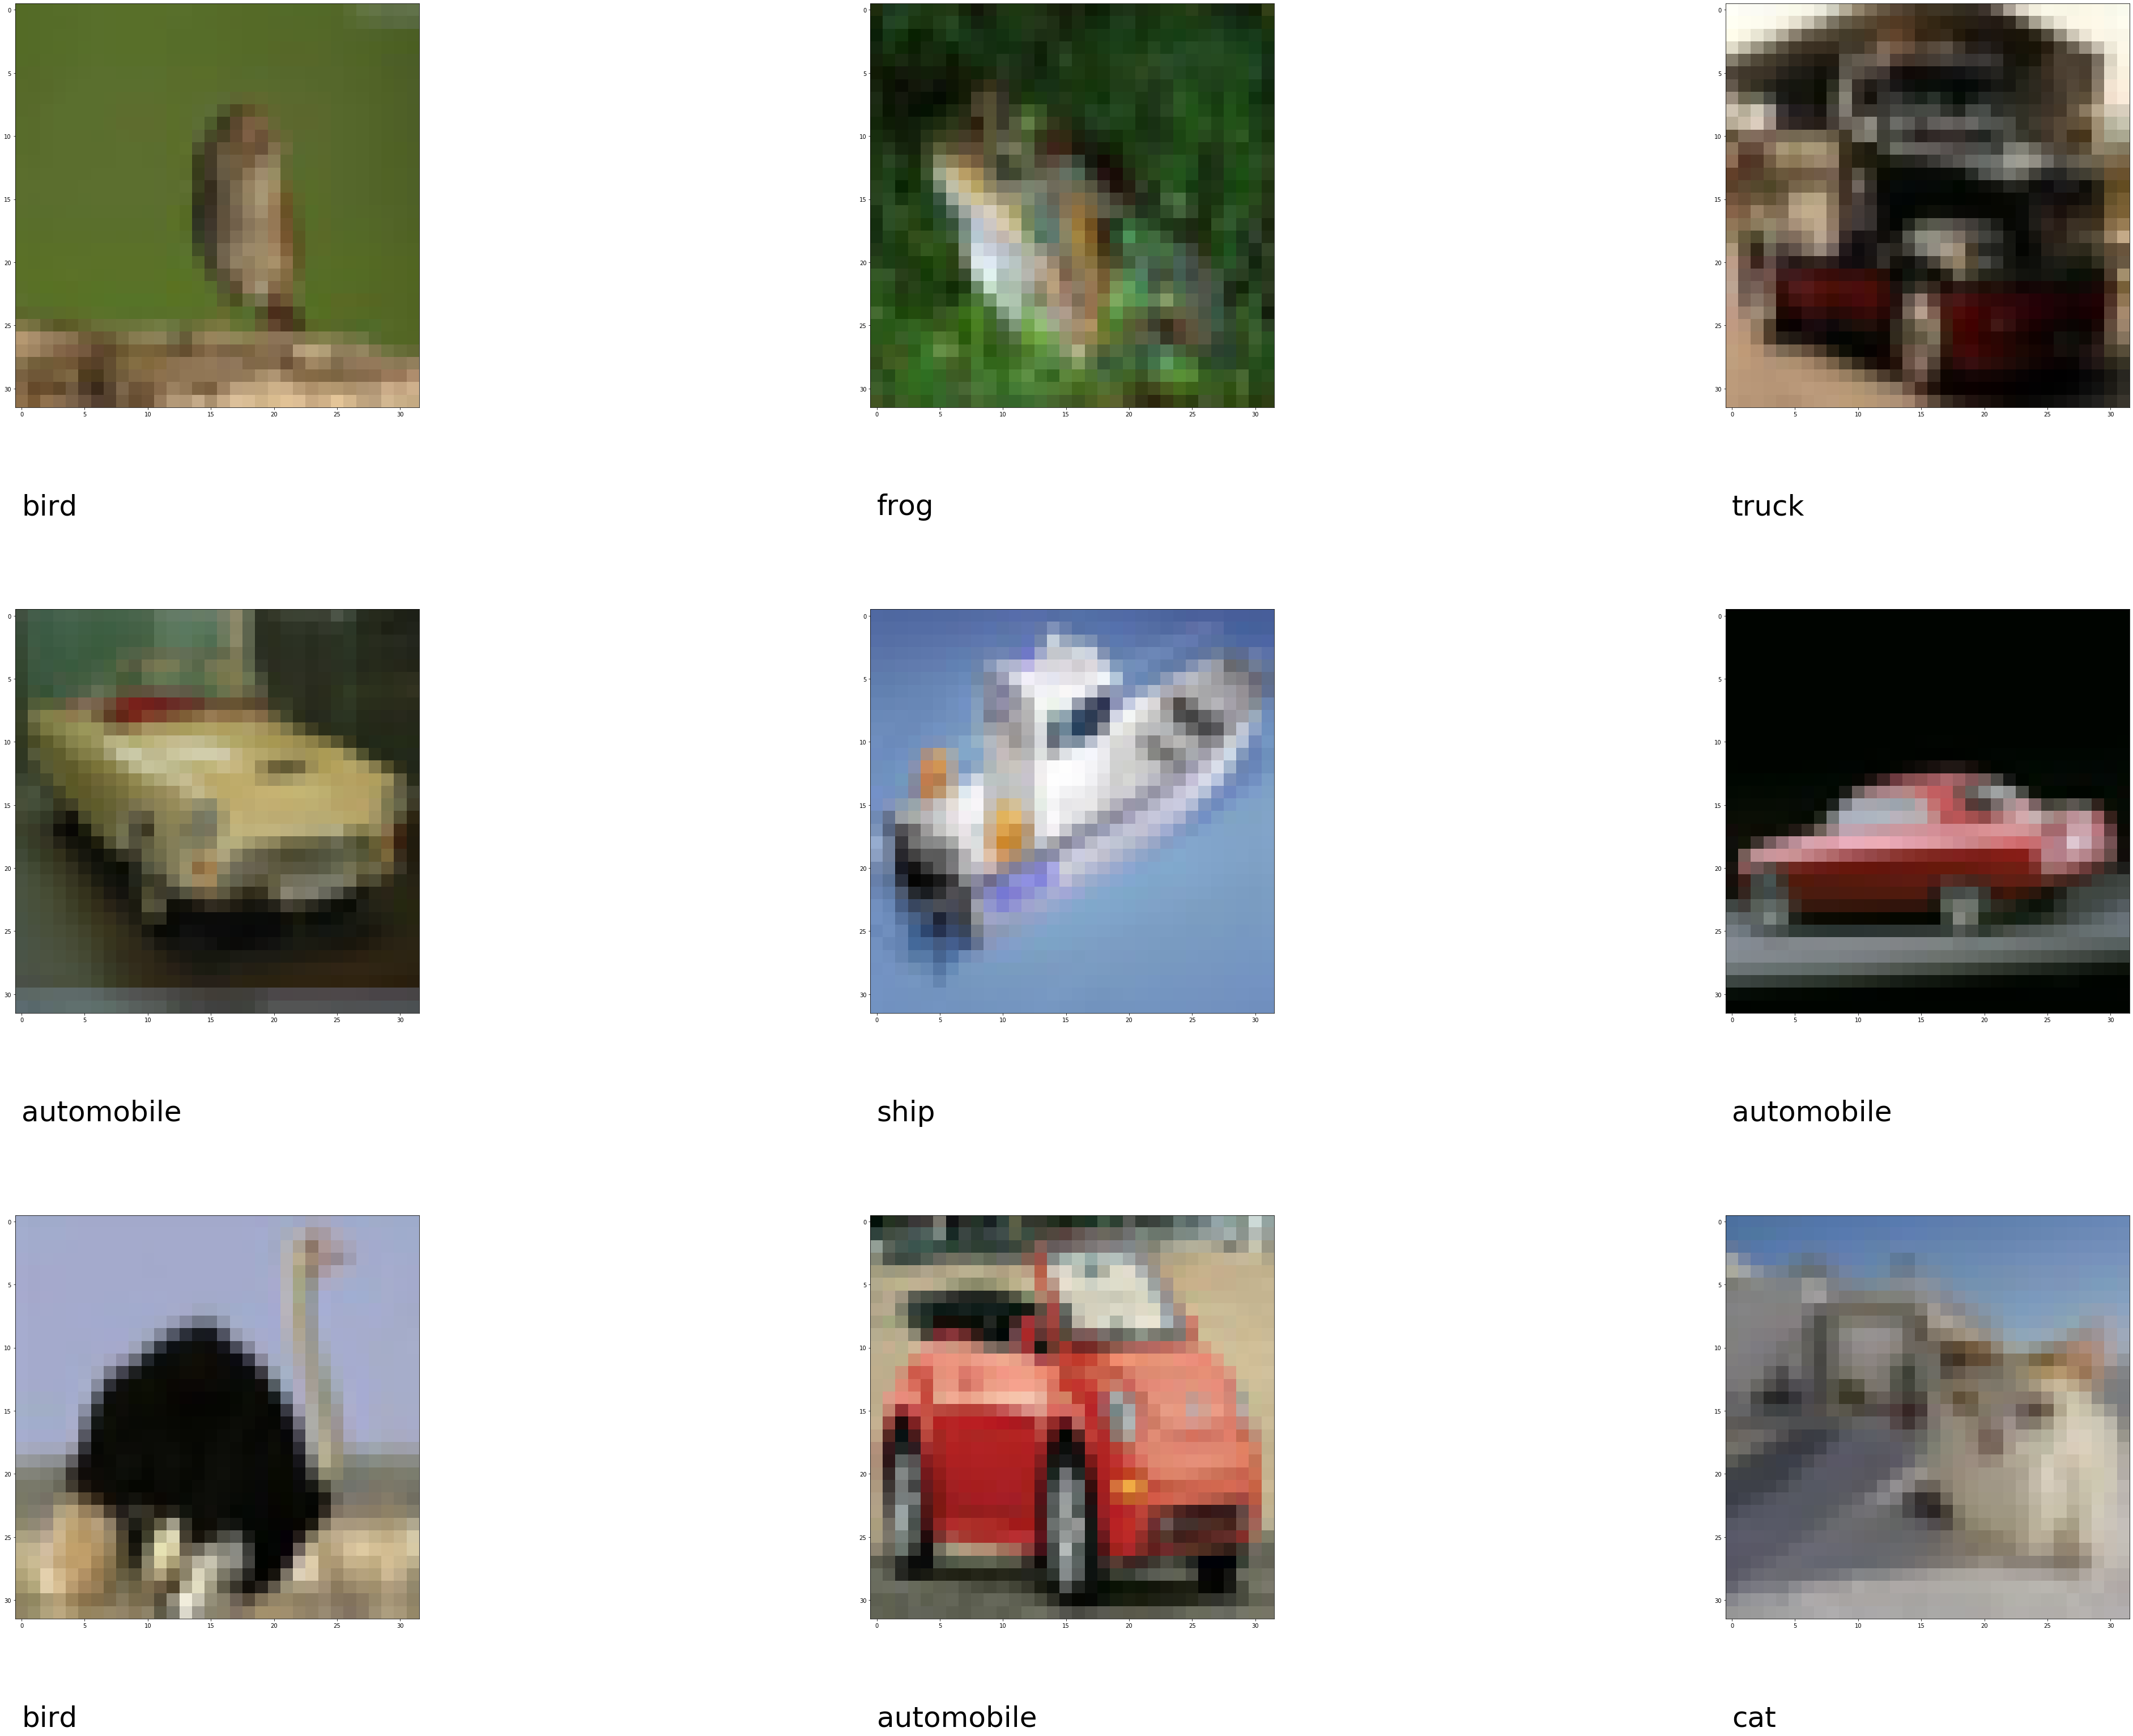

In [39]:
(trainX, trainY), (testX, testY) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



In [40]:

#trainX = trainX[:10000,:,:,:]
#testX = testX[:5000,:,:,:]

#trainY = trainY[:10000]
#testY = testY[:5000]

trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)


In [41]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

In [42]:
def create_model(conv1, conv2, conv3, dense):
    model = Sequential()
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if conv2 != 0:
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
    if conv3 != 0:
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_summary(history):
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    pyplot.legend(loc='lower right')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['acc'], color='blue', label='train')
    pyplot.plot(history['val_acc'], color='red', label='test')
    pyplot.legend(loc='lower right')

    
def create_or_load_model(name, model_params, train_func):
    model_path = 'models/{}.model'.format(name)
    history_path = 'models/{}_history.json'.format(name)
    if os.path.isfile(model_path) and not FORCE_BUILD_MODELS:
        model = load_model(model_path)
        with open(history_path) as file:
            history = json.load(file)
    else:
        model = create_model(*model_params)
        history = train_func(model)
        model.save(model_path)
        with open(history_path, 'w') as file:
            json.dump(history.history, file)
            history = history.history
    return (model, history)

## Tests

Wir teste ein sehr kleines Netz, welches nicht in der Lage ist, die Features ausreichend zu abstrahieren, aber nach vielen Episoden irgendwann trotzdem genug Kapazität hat, um die Daten zu erinnern. 

In [43]:
model_small, history_small = create_or_load_model('small', (3, 0, 0, 128), lambda model: model.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY)))



Parameter: 99,890
Final Accuracy: 0.9567; Final Validation Accuracy: 0.493


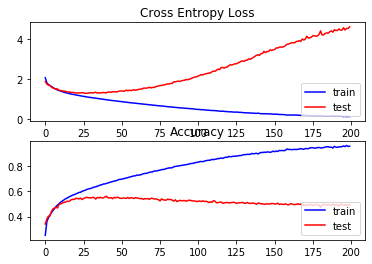

In [44]:
print("Parameter: {:,}".format(model_small.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_small['acc'][-1], history_small['val_acc'][-1]))
plot_summary(history_small)

Es zeigt sich, dass ein kleines Netz mit 33 576 Parametern nicht in der Lage ist, die Daten ausreichend zu generalisieren, aber trotzdem nach genug Trainingsepisoden die 50 000 Trainingsdaten erinnern kann. 

Als nächstes ein Netz einer "normalen" Größe, welches in der Lage ist, die CIFAR10 Challange in einem ausreichenden Maß zu meistern.

In [45]:
model_normal, history_normal = create_or_load_model('normal', (32, 64, 128, 512), lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

Parameter: 1,341,226
Final Accuracy: 1.0; Final Validation Accuracy: 0.7541


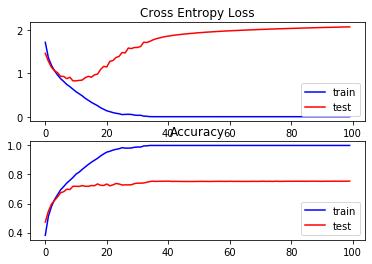

In [46]:
print("Parameter: {:,}".format(model_normal.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_normal['acc'][-1], history_normal['val_acc'][-1]))
plot_summary(history_normal)

Dieses Netz ist das gleiche wie oben, nur dass dieses mal die randomisierten Labels als Y-Daten genutzt werden.

In [47]:
model_random, history_random = create_or_load_model('random', (32, 64, 128, 512), lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64,  validation_data=(testX, testY)))


Parameter: 1,341,226
Final Accuracy: 0.98748; Final Validation Accuracy: 0.0997


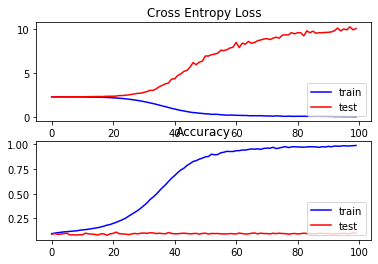

In [48]:
print("Parameter: {:,}".format(model_random.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_random['acc'][-1], history_random['val_acc'][-1]))
plot_summary(history_random)

## Vergleiche

Im folgenden Diagramm wird die Accuracy der Validationsets über 100 Episoden dargestellt.

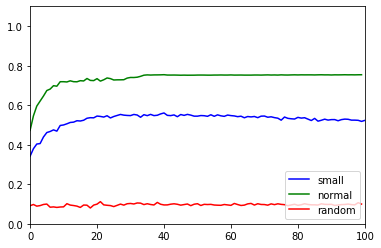

In [52]:
pyplot.plot(history_small['val_acc'], color='blue', label='small')
pyplot.plot(history_normal['val_acc'], color='green', label='normal')
pyplot.plot(history_random['val_acc'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Wenig überraschend ist die Performance des randomisierten Modells bei knapp 10%, was bei 10 Klassen genau der zu erwartenten Wahrscheinlichkeit einer rein zufälligen Klassenzuordnung entspricht. Das Modell hat aus den Trainingsdaten also keine Regeln zur Generalisierung ableiten können.



Das folgende Diagramm vergleicht die Accuracy der Trainingsdaten der 3 Versuche miteinander.

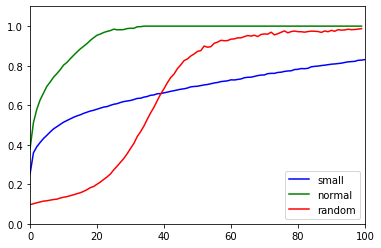

In [49]:
pyplot.plot(history_small['acc'], color='blue', label='small')
pyplot.plot(history_normal['acc'], color='green', label='normal')
pyplot.plot(history_random['acc'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Das obige Diagramm vergleicht die Accuracy der Trainingsdaten der 3 Versuche miteinander. A